# Regression Model for White Wine Quality Using Python and AutoKeras
### David Lowe
### October 9, 2020

Template Credit: Adapted from a template made available by Dr. Jason Brownlee of Machine Learning Mastery. [https://machinelearningmastery.com/]

SUMMARY: The purpose of this project is to construct a predictive model using various machine learning algorithms and to document the end-to-end steps using a template. The Wine Quality dataset is a regression situation where we are trying to predict the value of a continuous variable.

INTRODUCTION: The dataset is related to the white variants of the Portuguese "Vinho Verde" wine. The problem is to predict the wine quality using the chemical characteristics of the wine. Due to privacy and logistic issues, only physicochemical (inputs) and sensory (the output) variables are available (e.g., there is no data about grape types, wine brand, wine selling price).

ANALYSIS: In another iteration of modeling with TensorFlow, the performance of the preliminary model achieved an RMSE of 0.726. After tuning the hyperparameters, the best model processed the training dataset with an RMSE of 0.714. Furthermore, the final model processed the test dataset with an RMSE of 0.693.

After a series of modeling trials, the AutoKeras system processed the validation dataset with a minimum RMSE score of 0.562. When we applied the best AutoKeras model to the previously unseen test dataset, we obtained an RMSE score of 0.623.

CONCLUSION: In this iteration, the best TensorFlow model generated by AutoKeras appeared to be suitable for modeling this dataset. We should consider experimenting with AutoKeras for further modeling.

Dataset Used: Wine Quality Dataset

Dataset ML Model: Regression with numerical attributes

Dataset Reference: https://archive.ics.uci.edu/ml/datasets/wine+quality

Any predictive modeling machine learning project generally can be broken down into about five major tasks:

1. Prepare Environment
2. Summarize and Visualize Data
3. Pre-process Data
4. Train and Evaluate Models
5. Finalize Model and Present Analysis

## Task 1 - Prepare Environment

In [1]:
# Install the necessary packages for Colab
# !pip install python-dotenv PyMySQL

In [2]:
# Retrieve the GPU information from Colab
# gpu_info = !nvidia-smi
# gpu_info = '\n'.join(gpu_info)
# if gpu_info.find('failed') >= 0:
#     print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
#     print('and then re-execute this cell.')
# else:
#     print(gpu_info)

In [3]:
# Retrieve the memory configuration from Colab
# from psutil import virtual_memory
# ram_gb = virtual_memory().total / 1e9
# print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

# if ram_gb < 20:
#     print('To enable a high-RAM runtime, select the Runtime → "Change runtime type"')
#     print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
#     print('re-execute this cell.')
# else:
#     print('You are using a high-RAM runtime!')

In [4]:
# Retrieve the CPU information
ncpu = !nproc
print("The number of available CPUs is:", ncpu[0])

The number of available CPUs is: 4


In [5]:
# Clean up outstanding AutoKeras working folder and files
!rm -rf structured_data_regressor/

### 1.a) Load libraries and modules

In [6]:
# Set the random seed number for reproducible results
seedNum = 888

In [7]:
import random
random.seed(seedNum)
import numpy as np
np.random.seed(seedNum)
import pandas as pd
import matplotlib.pyplot as plt
import boto3
import math
from datetime import datetime
from dotenv import load_dotenv
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import tensorflow as tf
tf.random.set_seed(seedNum)
from tensorflow import keras
from autokeras import StructuredDataRegressor

### 1.b) Set up the controlling parameters and functions

In [8]:
# Begin the timer for the script processing
startTimeScript = datetime.now()

# Set up the number of CPU cores available for multi-thread processing
n_jobs = 1

# Set up the flag to stop sending progress emails (setting to True will send status emails!)
notifyStatus = False

# Set up the parent directory location for loading the dotenv files
useColab = False
if useColab:
    # Mount Google Drive locally for storing files
    from google.colab import drive
    drive.mount('/content/gdrive')
    gdrivePrefix = '/content/gdrive/My Drive/Colab_Downloads/'
    env_path = '/content/gdrive/My Drive/Colab Notebooks/'
    dotenv_path = env_path + "python_script.env"
    load_dotenv(dotenv_path=dotenv_path)

# Set up the dotenv file for retrieving environment variables
useLocalPC = False
if useLocalPC:
    env_path = "/Users/david/PycharmProjects/"
    dotenv_path = env_path + "python_script.env"
    load_dotenv(dotenv_path=dotenv_path)

# Set Pandas options
pd.set_option("display.max_rows", 500)
pd.set_option("display.width", 140)

# Set the percentage sizes for splitting the dataset
test_set_size = 0.2
val_set_size = 0.25

# Set the number of folds and iterations for cross validation
n_folds = 5

# Set various default modeling parameters
default_loss = 'mean_squared_error'
default_metrics = [tf.keras.metrics.RootMeanSquaredError()]
default_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
default_kernel_init = tf.keras.initializers.GlorotUniform(seed=seedNum)
default_epochs = 100
default_batch = 32
default_trials = 100

In [9]:
# Set up the email notification function
def status_notify(msg_text):
    access_key = os.environ.get('SNS_ACCESS_KEY')
    secret_key = os.environ.get('SNS_SECRET_KEY')
    aws_region = os.environ.get('SNS_AWS_REGION')
    topic_arn = os.environ.get('SNS_TOPIC_ARN')
    if (access_key is None) or (secret_key is None) or (aws_region is None):
        sys.exit("Incomplete notification setup info. Script Processing Aborted!!!")
    sns = boto3.client('sns', aws_access_key_id=access_key, aws_secret_access_key=secret_key, region_name=aws_region)
    response = sns.publish(TopicArn=topic_arn, Message=msg_text)
    if response['ResponseMetadata']['HTTPStatusCode'] != 200 :
        print('Status notification not OK with HTTP status code:', response['ResponseMetadata']['HTTPStatusCode'])

In [10]:
# Reset the random number generators
def reset_random(x):
    random.seed(x)
    np.random.seed(x)
    tf.random.set_seed(x)

In [11]:
if notifyStatus: status_notify("Task 1 - Prepare Environment has begun! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 1.c) Load dataset

In [12]:
dataset_path = 'https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv'
Xy_original = pd.read_csv(dataset_path, sep=";")

# Take a peek at the dataframe after import
Xy_original.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [13]:
Xy_original.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4898 entries, 0 to 4897
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         4898 non-null   float64
 1   volatile acidity      4898 non-null   float64
 2   citric acid           4898 non-null   float64
 3   residual sugar        4898 non-null   float64
 4   chlorides             4898 non-null   float64
 5   free sulfur dioxide   4898 non-null   float64
 6   total sulfur dioxide  4898 non-null   float64
 7   density               4898 non-null   float64
 8   pH                    4898 non-null   float64
 9   sulphates             4898 non-null   float64
 10  alcohol               4898 non-null   float64
 11  quality               4898 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 459.3 KB


In [14]:
Xy_original.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000
mean,6.854788,0.278241,0.334192,6.391415,0.045772,35.308085,138.360657,0.994027,3.188267,0.489847,10.514267,5.877909
std,0.843868,0.100795,0.121020,5.072058,0.021848,17.007137,42.498065,0.002991,0.151001,0.114126,1.230621,0.885639
min,3.800000,0.080000,0.000000,0.600000,0.009000,2.000000,9.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.300000,0.210000,0.270000,1.700000,0.036000,23.000000,108.000000,0.991723,3.090000,0.410000,9.500000,5.000000
50%,6.800000,0.260000,0.320000,5.200000,0.043000,34.000000,134.000000,0.993740,3.180000,0.470000,10.400000,6.000000
75%,7.300000,0.320000,0.390000,9.900000,0.050000,46.000000,167.000000,0.996100,3.280000,0.550000,11.400000,6.000000
max,14.200000,1.100000,1.660000,65.800000,0.346000,289.000000,440.000000,1.038980,3.820000,1.080000,14.200000,9.000000


In [15]:
Xy_original.isnull().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

In [16]:
print('Total number of NaN in the dataframe: ', Xy_original.isnull().sum().sum())

Total number of NaN in the dataframe:  0


### 1.d) Data Cleaning

In [17]:
# Not applicable for this iteration of the project

### 1.e) Splitting Data into Sets

In [18]:
# Use variable totCol to hold the number of columns in the dataframe
totCol = len(Xy_original.columns)

# Set up variable totAttr for the total number of attribute columns
totAttr = totCol-1

# targetCol variable indicates the column location of the target/class variable
# If the first column, set targetCol to 1. If the last column, set targetCol to totCol
# If (targetCol <> 1) and (targetCol <> totCol), be aware when slicing up the dataframes for visualization
targetCol = totCol

In [19]:
# We create attribute-only and target-only datasets (X_original and y_original)
# for various visualization and cleaning/transformation operations

if targetCol == totCol:
    X_original = Xy_original.iloc[:,0:totAttr]
    y_original = Xy_original.iloc[:,totAttr]
else:
    X_original = Xy_original.iloc[:,1:totCol]
    y_original = Xy_original.iloc[:,0]

print("Xy_original.shape: {} X_original.shape: {} y_original.shape: {}".format(Xy_original.shape, X_original.shape, y_original.shape))

Xy_original.shape: (4898, 12) X_original.shape: (4898, 11) y_original.shape: (4898,)


In [20]:
# Split the data further into training, validation, and test datasets
X_train_df, X_test_df, y_train_df, y_test_df = train_test_split(X_original, y_original, test_size=test_set_size, random_state=seedNum)
print("X_train_df.shape: {} y_train_df.shape: {}".format(X_train_df.shape, y_train_df.shape))
print("X_test_df.shape: {} y_test_df.shape: {}".format(X_test_df.shape, y_test_df.shape))

X_train_df.shape: (3918, 11) y_train_df.shape: (3918,)
X_test_df.shape: (980, 11) y_test_df.shape: (980,)


In [21]:
if notifyStatus: status_notify("Task 1 - Prepare Environment completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 2 - Summarize and Visualize Data

In [22]:
if notifyStatus: status_notify("Task 2 - Summarize and Visualize Data has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [23]:
# Set up the number of row and columns for visualization display. dispRow * dispCol should be >= totAttr
dispCol = 4
if totAttr % dispCol == 0 :
    dispRow = totAttr // dispCol
else :
    dispRow = (totAttr // dispCol) + 1
    
# Set figure width to display the data visualization plots
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = dispCol*4
fig_size[1] = dispRow*4
plt.rcParams["figure.figsize"] = fig_size

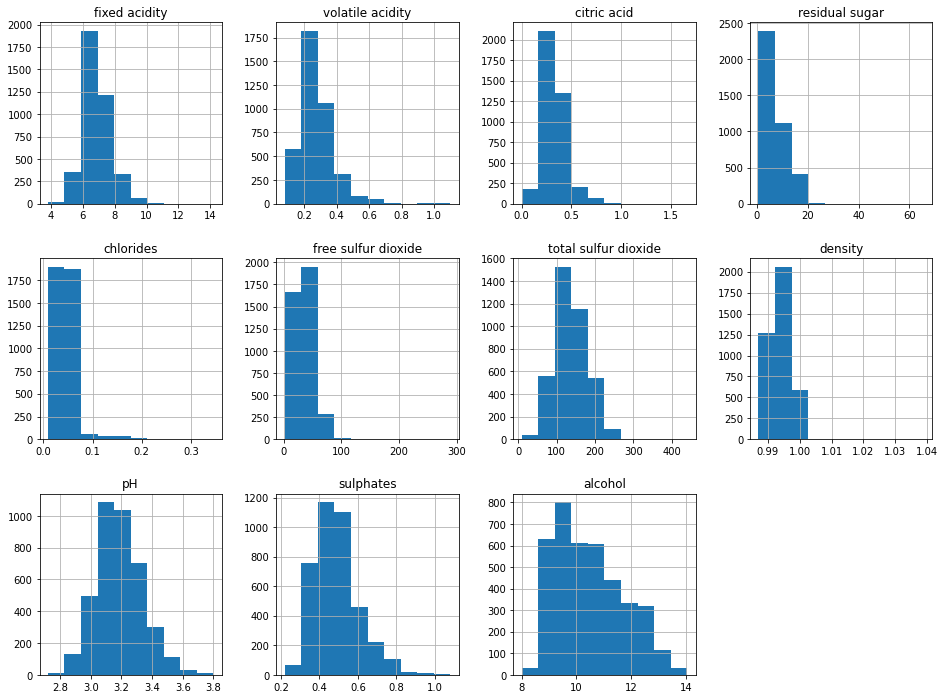

In [24]:
# Histograms for each attribute
X_train_df.hist(layout=(dispRow,dispCol))
plt.show()

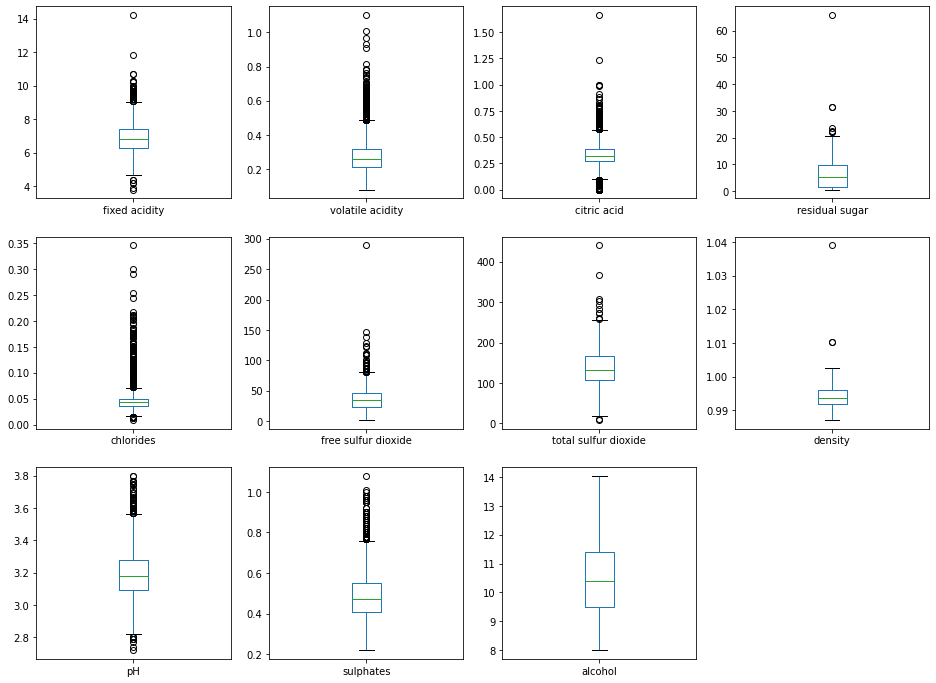

In [25]:
# Box and Whisker plot for each attribute
X_train_df.plot(kind='box', subplots=True, layout=(dispRow,dispCol))
plt.show()

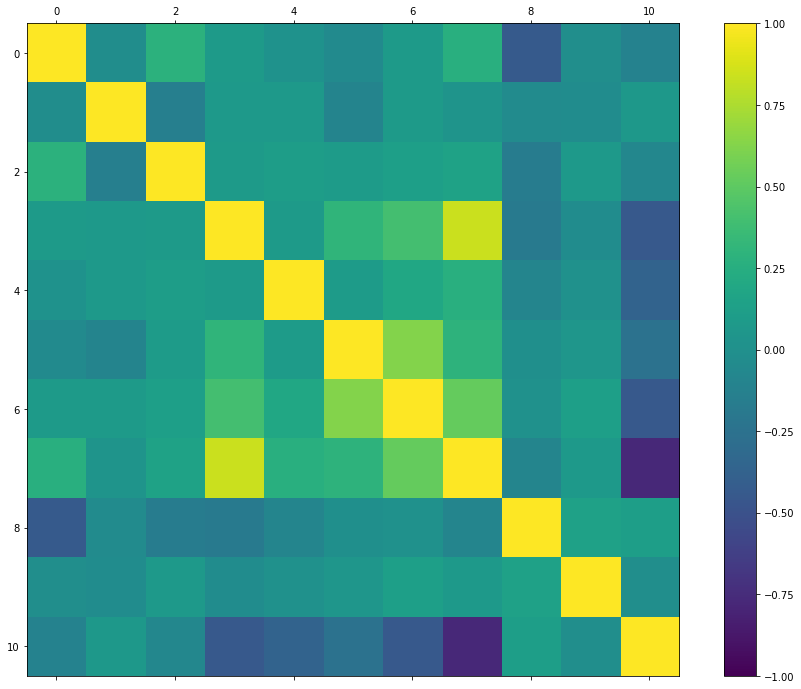

In [26]:
# Correlation matrix
fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(111)
correlations = X_train_df.corr(method='pearson')
cax = ax.matshow(correlations, vmin=-1, vmax=1)
fig.colorbar(cax)
plt.show()

In [27]:
if notifyStatus: status_notify("Task 2 - Summarize and Visualize Data completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 3 - Pre-process Data

In [28]:
if notifyStatus: status_notify("Task 3 - Pre-process Data has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 3.a) Feature Scaling

In [29]:
# Compose pipeline for the numerical and categorical features
numeric_columns = X_train_df.select_dtypes(include=['int','float']).columns
numeric_transformer = Pipeline(steps=[
#     ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
    ('scaler', preprocessing.StandardScaler())
])
categorical_columns = X_train_df.select_dtypes(include=['object','category']).columns
categorical_transformer = Pipeline(steps=[
#     ('imputer', SimpleImputer(strategy='constant', fill_value='NA')),
    ('onehot', preprocessing.OneHotEncoder(sparse=False, handle_unknown='ignore'))
])

print("Number of numerical columns:", len(numeric_columns))
print("Number of categorical columns:", len(categorical_columns))
print("Total number of columns in the dataframe:", X_train_df.shape[1])

Number of numerical columns: 11
Number of categorical columns: 0
Total number of columns in the dataframe: 11


In [30]:
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_columns)
#     ('cat', categorical_transformer, categorical_columns)
])
X_train = preprocessor.fit_transform(X_train_df)
print("Transformed X_train.shape:", X_train.shape)

Transformed X_train.shape: (3918, 11)


### 3.c) Training Data Balancing

In [31]:
# Not applicable for this iteration of the project

### 3.d) Feature Selection

In [32]:
# Not applicable for this iteration of the project

### 3.e) Display the Final Datasets for Model-Building

In [33]:
# Finalize the training and validation datasets for the modeling activities
y_train = y_train_df.ravel()
print("X_train.shape: {} y_train.shape: {}".format(X_train.shape, y_train.shape))

X_train.shape: (3918, 11) y_train.shape: (3918,)


In [34]:
if notifyStatus: status_notify("Task 3 - Pre-process Data completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 4 - Train and Evaluate Models

In [35]:
if notifyStatus: status_notify("Task 4 - Train and Evaluate Models has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [36]:
# Perform the model search
search = StructuredDataRegressor(loss=default_loss, metrics=default_metrics, max_trials=default_trials, seed=seedNum)
search.fit(x=X_train, y=y_train, epochs=default_epochs, validation_split=val_set_size, batch_size=default_batch, verbose=1)

Trial 71 Complete [00h 00m 39s]
val_loss: 0.5801743268966675

Best val_loss So Far: 0.5628060102462769
Total elapsed time: 00h 37m 17s
INFO:tensorflow:Oracle triggered exit
Epoch 1/100
123/123 [==============================] - 0s 3ms/step - loss: 11.9367 - root_mean_squared_error: 3.1202
Epoch 2/100
123/123 [==============================] - 0s 3ms/step - loss: 2.0256 - root_mean_squared_error: 1.4232
Epoch 3/100
123/123 [==============================] - 0s 3ms/step - loss: 1.7636 - root_mean_squared_error: 1.3280
Epoch 4/100
123/123 [==============================] - 0s 3ms/step - loss: 1.5684 - root_mean_squared_error: 1.2524
Epoch 5/100
123/123 [==============================] - 0s 3ms/step - loss: 1.3965 - root_mean_squared_error: 1.1817
Epoch 6/100
123/123 [==============================] - 0s 3ms/step - loss: 1.2452 - root_mean_squared_error: 1.1159
Epoch 7/100
123/123 [==============================] - 0s 3ms/step - loss: 1.1135 - root_mean_squared_error: 1.0552
Epoch 8/100
12

In [37]:
# Summarize the best performing model
auto_model = search.export_model()
auto_model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 11)]              0         
_________________________________________________________________
multi_category_encoding (Mul (None, 11)                0         
_________________________________________________________________
normalization (Normalization (None, 11)                23        
_________________________________________________________________
dense (Dense)                (None, 1024)              12288     
_________________________________________________________________
re_lu (ReLU)                 (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                16400     
_________________________________________________________________
re_lu_1 (ReLU)               (None, 16)               

In [38]:
# Display details about the chosen model
auto_model.to_json()

'{"class_name": "Functional", "config": {"name": "functional_1", "layers": [{"class_name": "InputLayer", "config": {"batch_input_shape": [null, 11], "dtype": "string", "sparse": false, "ragged": false, "name": "input_1"}, "name": "input_1", "inbound_nodes": []}, {"class_name": "Custom>MultiCategoryEncoding", "config": {"name": "multi_category_encoding", "trainable": true, "dtype": "float32", "encoding": ["int", "int", "int", "none", "int", "int", "none", "none", "int", "int", "int"]}, "name": "multi_category_encoding", "inbound_nodes": [[["input_1", 0, 0, {}]]]}, {"class_name": "Normalization", "config": {"name": "normalization", "trainable": true, "dtype": "float32", "axis": [-1]}, "name": "normalization", "inbound_nodes": [[["multi_category_encoding", 0, 0, {}]]]}, {"class_name": "Dense", "config": {"name": "dense", "trainable": true, "dtype": "float32", "units": 1024, "activation": "linear", "use_bias": true, "kernel_initializer": {"class_name": "GlorotUniform", "config": {"seed": n

In [39]:
if notifyStatus: status_notify("Task 4 - Train and Evaluate Models completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 5 - Finalize Model and Present Analysis

In [40]:
if notifyStatus: status_notify("Task 5 - Finalize Model and Present Analysis has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [41]:
# Apply the same data preparation steps to the test dataset
X_test = preprocessor.transform(X_test_df)
# Encode the target variable
y_test = y_test_df.ravel()
print("X_test.shape: {} y_test.shape: {}".format(X_test.shape, y_test.shape))

X_test.shape: (980, 11) y_test.shape: (980,)


In [42]:
# Evaluate the final model
loss, metric = search.evaluate(X_test, y_test, batch_size=default_batch, verbose=1)
print('The final metric (RMSE) on the test dataset: %.3f' % metric)

31/31 [==============================] - 0s 2ms/step - loss: 0.5324 - root_mean_squared_error: 0.6234
The final metric (RMSE) on the test dataset: 0.623


In [43]:
if notifyStatus: status_notify("Task 5 - Finalize Model and Present Analysis completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [44]:
print ('Total time for the script:',(datetime.now() - startTimeScript))

Total time for the script: 0:38:14.191479
